In [2]:
if True:
    import os
    os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'
    execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))
    import os
    import sys
else:
    os.environ['SPARK_HOME'] = '/usr/lib/spark'
    sys.path.insert(0, '/usr/lib/spark/python/lib/py4j-0.9-src.zip')
    sys.path.insert(0, '/usr/lib/spark/python/')
    sys.path.insert(0, '/usr/local/lib64/python2.7/site-packages')
    sys.path.insert(0,'/usr/local/lib/python2.7/site-packages')
    
    from pyspark import SparkContext
    from pyspark.sql import SQLContext, HiveContext
    
    try: sc = SparkContext()
    except: None    
    sqlc = SQLContext(sc)
    spark = sqlc

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import seaborn as sns

In [7]:
import numpy as np
import pandas as pd
import time
import json

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, MapType
import pyspark.sql.functions as F

In [8]:
from operator import add
from pyspark.sql.types import *

In [9]:
from pyspark.mllib.recommendation import Rating
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel
from datetime import datetime

# Load data

In [10]:
def convert_uir_tupple(line):
    r = line.split(',')
    return (int(r[0]), int(r[1]), float(r[2]))

def load_train(as_df=True):
    raw = sc.textFile("lab_12/input/train.csv")\
            .filter(lambda x: not x.startswith("userId"))\
            .map(convert_uir_tupple)
    if not as_df:
        return raw
    return raw.toDF(schema=StructType([StructField("userId",  IntegerType()),
                                           StructField("movieId", IntegerType()),
                                           StructField("rating",  FloatType())])) 
    return raw

In [11]:
train = load_train()

In [12]:
train.show(2)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|   2244|   4.5|
|     1|   2464|   4.5|
+------+-------+------+
only showing top 2 rows



# Split for train test

In [13]:
strain, stest = train.randomSplit([0.7, 0.3], seed=987)

In [14]:
print strain.count()
print stest.count()

7371649
3159915


# Baseline with Basic predictiors approach

In [15]:
smooth_buser = 5
smooth_bitem = 10

In [16]:
avg_rating = strain.agg({"rating":"mean"}).collect()[0]

In [17]:
avg_rating = avg_rating[0]
print 'avg rating', avg_rating

avg rating 3.5214315006


In [18]:
buser = strain.groupBy("userId").agg(F.sum(F.col("rating")).alias("sum_ratings"), 
                                     F.count(F.col("rating")).alias("n_user_ratings"))

In [19]:
buser.show(2)

+------+-----------+--------------+
|userId|sum_ratings|n_user_ratings|
+------+-----------+--------------+
|107231|       30.5|            10|
|107431|       56.0|            14|
+------+-----------+--------------+
only showing top 2 rows



In [20]:
x = buser.select("userId", 
                 F.col("sum_ratings").alias("user_sum_ratings"),
                 "n_user_ratings", 
                 ((F.col("sum_ratings") - F.lit(avg_rating)*F.col("n_user_ratings"))  / (F.col("n_user_ratings") + F.lit(smooth_buser))).alias("bpu"))

In [21]:
x.show(2)

+------+----------------+--------------+--------------------+
|userId|user_sum_ratings|n_user_ratings|                 bpu|
+------+----------------+--------------+--------------------+
|107231|            30.5|            10|-0.31428766706666666|
|107431|            56.0|            14| 0.35262942061052627|
+------+----------------+--------------+--------------------+
only showing top 2 rows



In [22]:
buser = x

In [23]:
buser.registerTempTable("buser")

In [24]:
x = spark.sql("""
        select 
           bu.*,
           case 
             when n_user_ratings <= 5 then 'unr_01_05' 
             when (n_user_ratings > 5 and n_user_ratings <= 50) then 'unr_06_50'
             when (n_user_ratings > 50) then 'unr_51'
             else 'unr_x' 
           end as nr_user_cat
        from buser bu
""")

In [25]:
buser = x

In [26]:
buser.show(2)

+------+----------------+--------------+--------------------+-----------+
|userId|user_sum_ratings|n_user_ratings|                 bpu|nr_user_cat|
+------+----------------+--------------+--------------------+-----------+
|    31|            54.0|            15|  0.0589263745500002|  unr_06_50|
|   231|           183.0|            52|-0.00200768475789...|     unr_51|
+------+----------------+--------------+--------------------+-----------+
only showing top 2 rows



In [27]:
buser.registerTempTable("buser")

In [28]:
strain.registerTempTable("strain")

In [29]:
bitem = spark.sql("""
            select
                t.movieId, sum(t.rating - %g - bu.bpu) as sum_r_normalised, count(*) n_item_ratings
            from strain t
            join buser bu on t.userId = bu.userId 
            group by t.movieId
""" % (avg_rating,))

In [30]:
bitem.show(2)

+-------+-----------------+--------------+
|movieId| sum_r_normalised|n_item_ratings|
+-------+-----------------+--------------+
|   7831|3116.763213237882|          7512|
|  24831|2203.538269262642|          5443|
+-------+-----------------+--------------+
only showing top 2 rows



In [31]:
x = bitem.select("movieId", "n_item_ratings", 
                 ( F.col("sum_r_normalised")  / (F.col("n_item_ratings") + F.lit(smooth_bitem))).alias("bpi"))

In [32]:
x.show(2)

+-------+--------------+-------------------+
|movieId|n_item_ratings|                bpi|
+-------+--------------+-------------------+
|   4231|          2538|-0.3958819292178841|
|   7831|          7512|0.41435299298562633|
+-------+--------------+-------------------+
only showing top 2 rows



In [33]:
x.registerTempTable("bitem")

In [34]:
x1 = spark.sql("""
        select 
           bi.*,
           case 
             when n_item_ratings <= 10  then 'inr_01_10' 
             when (n_item_ratings > 10 and n_item_ratings <= 100) then 'inr_11_100'
             when (n_item_ratings > 100) then 'inr_101'
             else 'inr_x' 
           end as nr_item_cat
        from bitem bi 
""")

In [35]:
x1.show(2)

+-------+--------------+--------------------+-----------+
|movieId|n_item_ratings|                 bpi|nr_item_cat|
+-------+--------------+--------------------+-----------+
|  24831|          5443| 0.40409651004266306|    inr_101|
|   4231|          2538|-0.39588192921788423|    inr_101|
+-------+--------------+--------------------+-----------+
only showing top 2 rows



In [36]:
bitem = x1

In [37]:
bitem.registerTempTable("bitem")

In [38]:
buser.show(2)

+------+----------------+--------------+-------------------+-----------+
|userId|user_sum_ratings|n_user_ratings|                bpu|nr_user_cat|
+------+----------------+--------------+-------------------+-----------+
|210631|            19.0|             5|0.13928424970000003|  unr_01_05|
|210831|            66.0|            18|0.11366230387826108|  unr_06_50|
+------+----------------+--------------+-------------------+-----------+
only showing top 2 rows



In [39]:
bitem.show(2)

+-------+--------------+-------------------+-----------+
|movieId|n_item_ratings|                bpi|nr_item_cat|
+-------+--------------+-------------------+-----------+
|  13031|            44|0.13902042395882072| inr_11_100|
|  24831|          5443|0.40409651004266317|    inr_101|
+-------+--------------+-------------------+-----------+
only showing top 2 rows



# Eval utils

In [40]:
def calc_rmse(df, prediction_column="predicted_rating"):
    mse = df.select(F.pow(F.col(prediction_column) - F.col("rating"), F.lit(2)).alias("err"))\
            .agg({"err":"mean"}).collect()[0][0]
    return np.sqrt(mse)    

## Build BP prediction for strain set

In [41]:
strain_predictions = spark.sql("""
        select 
            t.*,
            bu.user_sum_ratings,
            bu.n_user_ratings,
            bi.n_item_ratings,
            bu.nr_user_cat,
            bi.nr_item_cat,
            ({avg_rating} + bu.bpu + bi.bpi) as bp_rating,
            t.rating - ({avg_rating} + bu.bpu + bi.bpi) as bp_rating_err
        from strain t
        join buser bu on t.userId = bu.userId 
        join bitem bi on t.movieId = bi.movieId
""".format(avg_rating=avg_rating))

In [42]:
strain_predictions.show(2)

+------+-------+------+----------------+--------------+--------------+-----------+-----------+------------------+--------------------+
|userId|movieId|rating|user_sum_ratings|n_user_ratings|n_item_ratings|nr_user_cat|nr_item_cat|         bp_rating|       bp_rating_err|
+------+-------+------+----------------+--------------+--------------+-----------+-----------+------------------+--------------------+
| 37239|     31|   3.5|          1147.5|           325|           109|     unr_51|    inr_101|3.9026141509767505|-0.40261415097675046|
|134054|     31|   4.0|           338.5|           113|           109|     unr_51|    inr_101|3.3898436679422357|  0.6101563320577643|
+------+-------+------+----------------+--------------+--------------+-----------+-----------+------------------+--------------------+
only showing top 2 rows



## Build BP prediction for stest set

In [43]:
stest.registerTempTable("stest")

In [44]:
stest_predictions = spark.sql("""
        select 
            t.*,
            coalesce(bu.user_sum_ratings, 0.0) as user_sum_ratings,
            coalesce(bu.n_user_ratings, 0.0) as n_user_ratings,
            coalesce(bi.n_item_ratings, 0.0) as n_item_ratings,
            coalesce(bu.nr_user_cat, 'unr_0') as nr_user_cat,
            coalesce(bi.nr_item_cat, 'inr_0') as nr_item_cat,
            ({avg_rating} + coalesce(bu.bpu, 0.0) + coalesce(bi.bpi, 0.0)) as bp_rating,
            t.rating - ({avg_rating} + coalesce(bu.bpu, 0.0) + coalesce(bi.bpi, 0.0)) as bp_rating_err
        from stest t
        left join buser bu on t.userId = bu.userId 
        left join bitem bi on t.movieId = bi.movieId
""".format(avg_rating=avg_rating))

In [45]:
stest_predictions.show(2)

+------+-------+------+----------------+--------------+--------------+-----------+-----------+-----------------+-------------------+
|userId|movieId|rating|user_sum_ratings|n_user_ratings|n_item_ratings|nr_user_cat|nr_item_cat|        bp_rating|      bp_rating_err|
+------+-------+------+----------------+--------------+--------------+-----------+-----------+-----------------+-------------------+
|112036|     31|   4.0|          2777.0|         947.0|         109.0|     unr_51|    inr_101|3.307498121033836| 0.6925018789661639|
|223446|     31|   4.0|           135.0|          34.0|         109.0|  unr_06_50|    inr_101|4.284990439506121|-0.2849904395061209|
+------+-------+------+----------------+--------------+--------------+-----------+-----------+-----------------+-------------------+
only showing top 2 rows



## Cache BP results

In [46]:
#strain_predictions.coalesce(8).write.parquet("lab_12/cache/strain_bp_v1",
#                                             mode='overwrite')

In [47]:
#stest_predictions.coalesce(8).write.parquet("lab_12/cache/stest_bp_v1", 
#                                            mode='overwrite')

## RMSE per group

In [59]:
q = stest_predictions

In [60]:
qg=q.withColumn("e2", F.pow(F.col("bp_rating_err"), 2))\
 .groupBy(["nr_user_cat", "nr_item_cat"])\
 .agg(F.sum(F.col("e2")).alias("ttl_e2"), F.count(F.col("e2")).alias("n_examples"))

In [61]:
epg = qg.toPandas()

In [62]:
epg['rmse'] = np.sqrt(epg['ttl_e2'] / epg['n_examples'])

In [63]:
epg['r_examples'] = np.round(epg['n_examples'] * 100. /  epg['n_examples'].sum(), 2)

In [64]:
epg.sort_values(by='rmse')

,nr_user_cat,nr_item_cat,ttl_e2,n_examples,rmse,r_examples
0,unr_51,inr_101,1.474196e+06,2016442,0.855037,63.81
4,unr_51,inr_11_100,6.759608e+04,88496,0.873975,2.80
11,unr_51,inr_01_10,9.852520e+03,12069,0.903521,0.38
8,unr_06_50,inr_101,7.737560e+05,900019,0.927206,28.48
1,unr_51,inr_0,1.418454e+03,1610,0.938631,0.05
3,unr_01_05,inr_101,1.343249e+05,122519,1.047072,3.88
9,unr_06_50,inr_11_100,1.358710e+04,11725,1.076483,0.37
13,unr_0,inr_101,5.201713e+03,3962,1.145819,0.13
5,unr_06_50,inr_01_10,1.585268e+03,1130,1.184437,0.04
6,unr_01_05,inr_11_100,2.223347e+03,1572,1.189262,0.05


### Distribution of an ratings error compared ti basic predictors

In [65]:
q=strain_predictions.select("bp_rating_err").sample(False, 0.1).toPandas()

In [66]:
q.describe()

,bp_rating_err
count,737501.000000
mean,-0.004622
std,0.865934
min,-4.434679
25%,-0.487850
50%,0.061946
75%,0.567066
max,4.404782


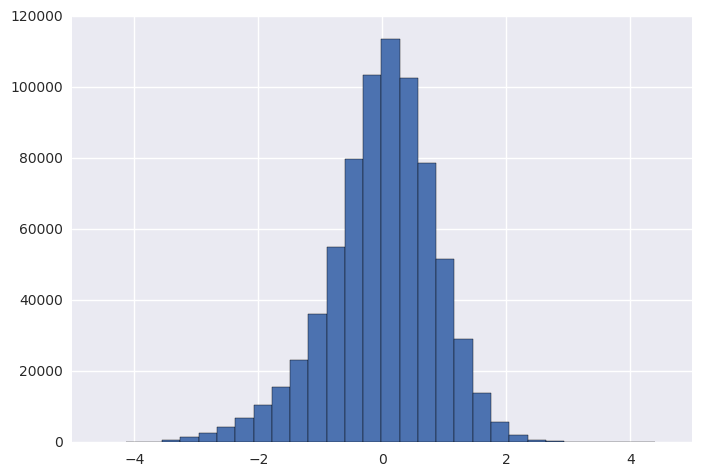

In [67]:
q.bp_rating_err.hist(bins=30)

# ALS on exact ratings

## Prepeare train,validate,test data

In [170]:
strain_predictions.rdd.take(1)

[Row(userId=75052, movieId=148, rating=3.0, n_user_ratings=238, n_item_ratings=1, nr_user_cat=u'unr_51', nr_item_cat=u'inr_01_10', bp_rating=3.417542048157108, bp_rating_err=-0.41754204815710816)]

In [171]:
def convert_to_als_rating(r):
    return Rating(r.userId, r.movieId, r.rating)

In [172]:
strain_ratings = strain_predictions.rdd.map(convert_to_als_rating)

In [173]:
strain_ratings.first()

Rating(user=75052, product=148, rating=3.0)

In [174]:
stest_ratings = stest_predictions.rdd.map(convert_to_als_rating)

In [175]:
stest_ratings.first()

Rating(user=109268, product=148, rating=3.0)

In [176]:
als_train, als_val = strain_ratings.randomSplit([0.7,0.3], seed=23)

In [177]:
als_train.count()

5159147

In [178]:
als_val.count()

2212531

## ALS eval utils

In [185]:
def cut_1to5(x):
    if x < 1.:
        return 1.0
    if x > 5:
        return 5.0
    return x

def als_evaluate_model(model, dataset):
    testdata = dataset.map(lambda x: (x[0],x[1]))
    predictions_raw = model.predictAll(testdata)
    # 1
    predictions = predictions_raw.map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = dataset.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE_1 = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).reduce(lambda x, y: x + y) / ratesAndPreds.count()
    RMSE_1 = np.sqrt(MSE_1)
    # 2
    MSE_2 = ratesAndPreds.map(lambda r: (r[1][0] - cut_1to5(r[1][1]))**2).reduce(lambda x, y: x + y) / ratesAndPreds.count()
    RMSE_2 = np.sqrt(MSE_2)
    
    return RMSE_1,RMSE_2

## Grid search for ALS parameters

In [181]:
als_train.cache()
als_val.cache()

PythonRDD[8960] at RDD at PythonRDD.scala:48

In [183]:
numIterations = 10
ps = []
for rank in [10,20]:#range(10, 201,10):
    start = datetime.now()
    print start,
    model = ALS.train(als_train, rank, numIterations)
    train_rmse = als_evaluate_model(model, als_train)
    val_rmse = als_evaluate_model(model, als_val)
    duration = datetime.now() - start
    print 'rank=%d train_rmse=%6.5f val_rmse=%6.5f took=%d sec' % (rank, train_rmse, val_rmse, duration.seconds)
    ps.append((rank, train_rmse, val_rmse))

2016-12-18 17:48:20.364772 rank=10 train_rmse=0.63410 val_rmse=0.76568 took=133 sec
2016-12-18 17:50:34.145181 rank=20 train_rmse=0.53354 val_rmse=0.73671 took=93 sec


In [167]:
ps

[(5, 0.78287368897483978, 0.78832140157926001),
 (10, 0.75676682634959458, 0.76708622055869624),
 (15, 0.73693453096207562, 0.74675799552790767),
 (20, 0.73030874550398917, 0.740489527600804),
 (20, 0.5338390029293324, 0.73957902944231724),
 (30, 0.46546160491736766, 0.724873019750924),
 (40, 0.4100523971658615, 0.71151068988417243),
 (50, 0.36603992789742479, 0.70201629979609759),
 (60, 0.32711980126882767, 0.69005508263042326),
 (70, 0.29629728152964235, 0.68619275479997965),
 (80, 0.26777211981179505, 0.66925161123813126),
 (90, 0.24522468870530914, 0.66572985643820137),
 (100, 0.22498306163593854, 0.65752046651833784),
 (110, 0.20832552757682693, 0.65476757381529338),
 (120, 0.19371653987983492, 0.64954671599212666),
 (130, 0.18081538183972939, 0.63976864463117245),
 (140, 0.16981775608990526, 0.6307760929790569),
 (150, 0.16140734118470276, 0.62957435104417547),
 (160, 0.15271302296293113, 0.62000769604332095),
 (170, 0.14713646861418861, 0.62535333678368921),
 (180, 0.14141468442

In [168]:
numIterations = 10
tps = []
for rank in [5, 10, 120, 200]:
    start = datetime.now()
    print start,
    model = ALS.train(strain_ratings, rank, numIterations)
    train_rmse = als_evaluate_model(model, strain_ratings)
    test_rmse = als_evaluate_model(model, stest_ratings)
    duration = datetime.now() - start
    print 'rank=%d train_rmse=%6.5f test_rmse=%6.5f took=%d sec' % (rank, train_rmse, test_rmse, duration.seconds)
    tps.append((rank, train_rmse, test_rmse))

2016-12-18 17:03:22.240524 rank=5 train_rmse=0.73092 test_rmse=0.89693 took=131 sec
2016-12-18 17:05:34.165706 rank=20 train_rmse=0.57468 test_rmse=0.98567 took=143 sec
2016-12-18 17:07:57.333323 rank=120 train_rmse=0.25887 test_rmse=1.05798 took=338 sec
2016-12-18 17:13:35.681151 rank=200 train_rmse=0.17934 test_rmse=1.01971 took=566 sec


In [169]:
tps

[(5, 0.73092347623852438, 0.89693131089203759),
 (20, 0.57467597436330375, 0.98567417441713601),
 (120, 0.25886660409037371, 1.0579792520783937),
 (200, 0.17934196897921104, 1.0197119786899993)]

In [ ]:
#tps=[]

In [ ]:
for numIterations in [50]:
    for lambda_ in [0.1]:
        #for rank in [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]:
        for rank in [25]:
            x = [z for z in tps if z[0] == rank and z[1] == numIterations and z[2] == lambda_]
            if x:
                print 'cached', rank, numIterations, lambda_
                continue
            start = datetime.now()
            print start,
            model = ALS.train(strain_ratings, rank, numIterations, lambda_=lambda_, seed=19)
            print '!',
            train_rmse = als_evaluate_model(model, strain_ratings)
            test_rmse_f, test_rmse_c = als_evaluate_model(model, stest_ratings)
            duration = datetime.now() - start
            print 'rank=%d ni=%d lambda=%f train_rmse=%6.5f test_rmse=%6.5f test_rmse_cut=%6.5f took=%d sec' % (rank, 
                                                 numIterations, lambda_,
                                                 train_rmse[0], test_rmse_f, test_rmse_c, 
                                                 duration.seconds)
            tps.append((rank, numIterations, lambda_, train_rmse[0], train_rmse[1], test_rmse_f, test_rmse_c))

In [247]:
import cPickle as pickle

In [248]:
#with open("als_hp_grid_abs_ratings.pckl", 'w') as h:
#    pickle.dump(tps, h)

In [249]:
zz=pd.DataFrame.from_records(tps,columns=['rank','n_iter','lambda_',
                                          "train_rmse_c", "train_rmse_f", "test_rmse_f", "test_rmse_c"])

In [250]:
zz.sort_values(by='test_rmse_c').head(10)

,rank,n_iter,lambda_,train_rmse_c,train_rmse_f,test_rmse_f,test_rmse_c
43,25,30,0.1,0.684961,0.685165,0.832534,0.832064
40,20,30,0.1,0.691218,0.691411,0.832634,0.832130
44,30,30,0.1,0.680688,0.680899,0.832682,0.832218
39,20,20,0.1,0.692949,0.693142,0.833711,0.833198
42,25,20,0.1,0.687234,0.687438,0.834182,0.833701
29,20,15,0.1,0.695032,0.695224,0.834936,0.834413
41,25,15,0.1,0.690026,0.690231,0.836283,0.835787
27,10,15,0.1,0.718896,0.719044,0.836555,0.835897
20,20,10,0.1,0.699451,0.699643,0.837456,0.836919
13,12,10,0.1,0.715086,0.715245,0.837860,0.837239


In [228]:
def cut_1to5(x):
    if x < 1.:
        return 1.0
    if x > 5:
        return 5.0
    return x

udf_cut_1to5 = F.udf(cut_1to5, FloatType())

In [229]:
def make_predictions_df(model, df):
    testdata = df.rdd.map(lambda x: (x.userId, x.movieId))
    predictions = model.predictAll(testdata)
    return predictions.toDF(schema=StructType([StructField("userId",  IntegerType()),
                                               StructField("movieId", IntegerType()),
                                               StructField("predicted_rating",  FloatType())]))

In [230]:
q = make_predictions_df(model, stest_predictions)

In [231]:
q.show(3)

+------+-------+----------------+
|userId|movieId|predicted_rating|
+------+-------+----------------+
| 59300|   9725|        4.038461|
|228300|  13119|        3.759715|
|228300|  22925|       4.2917476|
+------+-------+----------------+
only showing top 3 rows



In [232]:
qq=stest_predictions.join(q, on=["userId","movieId"])\
                    .select("userId","movieId","rating", 
                            udf_cut_1to5(F.col("predicted_rating")).alias("predicted_rating"))

In [234]:
qq.show(3)

+------+-------+------+----------------+
|userId|movieId|rating|predicted_rating|
+------+-------+------+----------------+
|    12|  10386|   4.0|       3.2053645|
|    28|   6772|   3.5|       3.4075706|
|    28|  22903|   2.5|       3.3466327|
+------+-------+------+----------------+
only showing top 3 rows



In [235]:
print calc_rmse(qq, prediction_column="predicted_rating")

0.832811630144
